# Mapping of the data to HLCA

Mostly based on [this repository](https://github.com/LungCellAtlas/mapping_data_to_the_HLCA)

In this notebook, we will guide you through how to map your data to the [Human Lung Cell Atlas](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) (core reference), perform label transfer, and more. For that purpose we use scArches, a method to map new single cell/single nucleus data to an existing reference (see also [Lotfollahi et al., Nature Biotechnology 2021](https://doi.org/10.1038/s41587-021-01001-7)). 

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scarches as sca
import scvi
import seaborn as sns
import matplotlib.pyplot as plt

 captum (see https://github.com/pytorch/captum).
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/home/icb/vladimir.shitov/software/miniconda3/envs/HLCA_mapping_env/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/icb/vladimir.shitov/software/miniconda3/envs/HLCA_mapping_env/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
sca.__version__

'0.5.5'

In [3]:
import sys
sys.path.append("../scripts/")
import scarches_label_transfer

In [ ]:
# Mapping between names of the genes and ENSEMBL IDs
# Source: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/blob/main/supporting_files/HLCA_scarches_gene_order.csv
path_gene_order = "../supporting_files/HLCA_scarches_gene_order.csv"

# Levels of cell type annotation for HLCA
# Source: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/blob/main/supporting_files/HLCA_celltypes_ordered.csv
path_HLCA_celltype_info = "../supporting_files/HLCA_celltypes_ordered.csv"

# Embedding of HLCA extended by disease datasets
path_embedding = "/lustre/groups/ml01/workspace/hlca_lisa.sikkema_malte.luecken/HLCA_reproducibility/data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"

# Path to HLCA model directory created with scvi < 0.15
dir_old_model = "/lustre/groups/ml01/workspace/hlca_lisa.sikkema_malte.luecken/HLCA_reproducibility/results/scANVI_integration/scanvi_model"

# Path to HLCA model converted to a newer version (will be created by code) 
dir_ref_model = "/home/icb/vladimir.shitov/HLCA_converted_model/"

# Path to PCLS data
PROCESSED_DATA_PATH = "../data/221117_PCLS_processed_for_mapping.h5ad"

dir_out = "../2022_11_PCLS"

In [5]:
KL_WEIGHT = 0.5  # Also tried 1.5 and 0
KL_NAME = "_KL_0_5"

In [6]:
sc.set_figure_params(figsize=(5,5))

In [7]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         5.4.1
absl                        NA
attr                        22.1.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
charset_normalizer          2.1.1
chex                        0.1.5
contextlib2                 NA
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
decorator                   5.1.1
deprecate                   0.3.2
docrep                      0.3.2
entrypoints                 0.4
flax                        0.6.2
fsspec                      2022.11.0
google                      NA
h5py                        3.7.0
idna                        3.4
igraph                      0.10.2
ipykernel                   5.5.5
ipython_genutils            0.2.0
ipywidgets                  8.0.2
jax         

# Convert HLCA reference model to a new format

In [25]:
scvi.model.SCANVI.convert_legacy_save(dir_old_model, dir_ref_model)

# Load data for mapping

In [7]:
# gene order for scArches model
reference_gene_order = pd.read_csv(path_gene_order)
# reference embedding, including cell/sample/subject metadata:
reference_embedding = sc.read_h5ad(path_embedding)

In [8]:
reference_gene_order

,gene_id,gene_symbol
0,ENSG00000000938,FGR
1,ENSG00000000971,CFH
2,ENSG00000002587,HS3ST1
3,ENSG00000002933,TMEM176A
4,ENSG00000003436,TFPI
...,...,...
1995,ENSG00000280721,AC133644.2
1996,ENSG00000281103,TRG-AS1
1997,ENSG00000282122,CH17-262H11.1
1998,ENSG00000282988,RP1-34B20.21


In [9]:
reference_embedding

AnnData object with n_obs × n_vars = 2382658 × 30
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 'l

In [12]:
query_data = sc.read(PROCESSED_DATA_PATH)
query_data

AnnData object with n_obs × n_vars = 63581 × 2000
    obs: 'condition', 'modality', 'name', 'patient', 'timepoint', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group', 'scanvi_label', 'dataset'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'float_counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

In [13]:
query_batches = query_data.obs["dataset"].unique()
batch_variable = "dataset"

In [14]:
SUFFIX = "_HLCA_subset"

# Subset conditions of interest

In [15]:
reference_embedding.obs["condition"].value_counts()

Healthy                                      1123778
IPF                                           351617
COVID-19                                      298429
Healthy (tumor adjacent)                      176937
COPD                                           67943
Lung adenocarcinoma                            62807
Systemic sclerosis-associated ILD              57287
COVID-19 severe                                36073
Pneumonia non-COVID                            31923
Chronic rhinitis                               29137
Large Cell Carcinoma                           21167
Squamous Cell Carcinoma                        20631
CF                                             17590
End-stage lung fibrosis, unknown etiology      17526
Lymphangioleiomyomatosis                       12374
Pleiomorphic Carcinoma                         10765
HP                                             10379
NSIP                                            8597
COVID-19 moderate                             

In [17]:
interesting_conditions = ["IPF",
                          "Systemic sclerosis-associated ILD",
                          "End-stage lung fibrosis, unknown etiology",
                          "Myositis-associated ILD",
                          "ILD"]

In [18]:
reference_embedding.shape

(2382658, 30)

Subset cells that are either part of core atlas or in the interesting conditions

In [19]:
cells_to_take = (reference_embedding.obs["condition"].isin(interesting_conditions)) | \
                (reference_embedding.obs["core_or_extension"] == "core")

reference_embedding = reference_embedding[cells_to_take, :].copy()
reference_embedding.shape

(1022543, 30)

In [20]:
reference_embedding.obs["study"].value_counts()

Banovich_Kropski_2020     183568
Kaminski_2020             144404
Barbry_unpubl             100211
Misharin_Budinger_2018     75473
Barbry_Leroy_2020          74487
Nawijn_2021                70402
Misharin_2021              64843
Krasnow_2020               60982
Sheppard_2020              52234
Jain_Misharin_2021         45557
Meyer_2019                 35554
Seibold_2020               33593
Lafyatis_2019              27297
Lafyatis_Rojas_2019        24181
Schiller_2020              17526
Teichmann_Meyer_2019       12231
Name: study, dtype: int64

# Map to the extended HLCA

Check that genes order is the same in query and the reference

In [21]:
if (query_data.var.index == reference_gene_order.gene_symbol).all() or (
    query_data.var.index == reference_gene_order.gene_id
).all():
    print("Gene order is correct.")
else:
    print(
        "WARNING: your gene order does not match the order of the HLCA reference. Fix this before continuing!"
    )

Gene order is correct.


Check that `X` matrix of the query contains raw counts

In [22]:
query_data.X[:10, :10].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [23]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [28]:
for batch in query_batches: # this loop is only necessary if you have multiple batches, but will also work for a single batch.
    print("Batch:", batch)
    query_subadata = query_data[query_data.obs[batch_variable] == batch,:].copy()
    print("Shape:", query_subadata.shape)
    # load model and set relevant variables:
    model = sca.models.SCANVI.load_query_data(
        query_subadata,
        dir_ref_model,
        freeze_dropout = True,
    )
        
    scvi.model.SCANVI.prepare_query_anndata(query_subadata, model)
    
    # now train surgery model using reference model and target adata
    model.train(
        max_epochs=surgery_epochs,
        early_stopping=True,
        early_stopping_monitor="elbo_validation",
        early_stopping_patience=10,
        early_stopping_min_delta=0.001,
        check_val_every_n_epoch=1,
        plan_kwargs=dict(kl_weight=KL_WEIGHT,
                         weight_decay=0)
    )
    surgery_path = os.path.join(dir_out, batch + SUFFIX + KL_NAME)
    if not os.path.exists(surgery_path):
        os.makedirs(surgery_path)
    model.save(surgery_path, overwrite=True)

Batch: PCLS
Shape: (63581, 2000)
INFO     File /home/icb/vladimir.shitov/HLCA_converted_model/model.pt already downloaded                           


INFO     Found 100.0% reference vars in query data.                                                                
INFO     Training for 500 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 42/500:   8%|▊         | 42/500 [04:52<53:09,  6.96s/it, loss=537, v_num=1]
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 640.523. Signaling Trainer to stop.


In [29]:
model.history.keys()

dict_keys(['train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

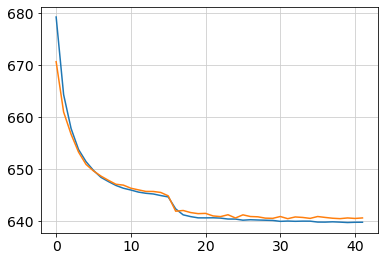

In [30]:
plt.plot(model.history["elbo_train"])
plt.plot(model.history["elbo_validation"])

# Load trained model

In [9]:
batch = "PCLS"
surgery_path = f"{dir_out}/{batch}{SUFFIX}{KL_NAME}"
model = sca.models.SCANVI.load(surgery_path, query_data) # if already trained

In [32]:
emb_df = pd.DataFrame(index=query_data.obs.index, columns=range(0,reference_embedding.shape[1]))
emb_df.shape

(63581, 30)

In [ ]:
for batch in query_batches: # from small to large datasets
    print(f"Working on {batch}...")
    query_subadata = query_data[query_data.obs[batch_variable] == batch,:].copy()
    surgery_path = os.path.join(dir_out, batch + SUFFIX + KL_NAME)
    model = sca.models.SCANVI.load(surgery_path, query_subadata)
    query_subadata_latent = sc.AnnData(model.get_latent_representation(adata=query_subadata))
    # copy over .obs
    # query_subadata_latent.obs = query_data.obs.loc[query_subadata.obs.index,:]
    query_subadata_latent.obs = query_data.obs
    query_subadata_latent.write(os.path.join(surgery_path, f"emb{KL_NAME}.h5ad"))
    emb_df.loc[query_subadata.obs.index,:] = query_subadata_latent.X

In [34]:
(emb_df.index == query_subadata_latent.obs_names).all()

True

In [ ]:
emb_df.loc[:] = query_subadata_latent.X
emb_df

In [36]:
query_subadata_latent = sc.read(os.path.join(surgery_path, f"emb{KL_NAME}.h5ad"))
query_subadata_latent

AnnData object with n_obs × n_vars = 63581 × 30
    obs: 'condition', 'modality', 'name', 'patient', 'timepoint', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group', 'scanvi_label', 'dataset', '_scvi_batch', '_scvi_labels'

In [37]:
query_embedding = sc.AnnData(X=emb_df.values, obs=query_data.obs)

In [38]:
query_embedding.obs['HLCA_or_query'] = "query"
reference_embedding.obs['HLCA_or_query'] = "HLCA"

In [39]:
# concatenate source and target data
combined_emb = reference_embedding.concatenate(query_embedding, index_unique=None)
combined_emb

/home/icb/vladimir.shitov/software/miniconda3/envs/HLCA_mapping_env/lib/python3.7/site-packages/anndata/_core/merge.py:863: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_annot[label] = label_col


AnnData object with n_obs × n_vars = 1086124 × 30
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 'l

In [40]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

In [80]:
sc.set_figure_params(figsize=(5,5), dpi=100)

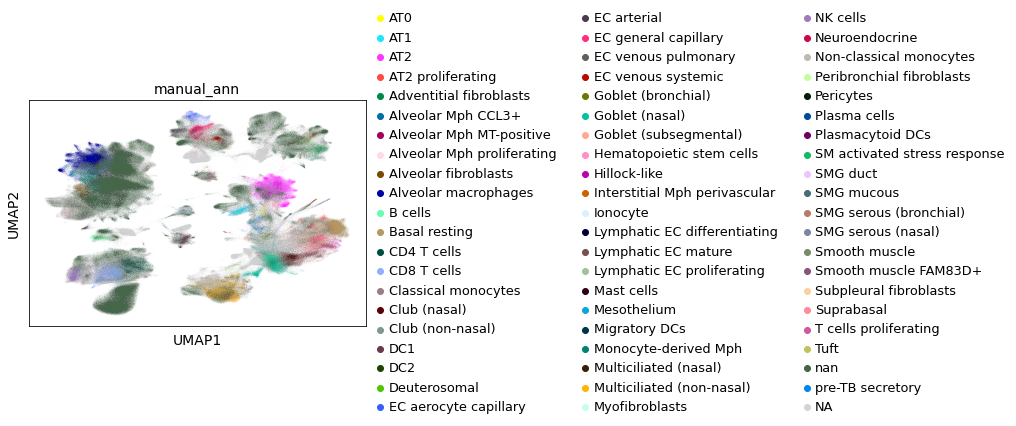

In [61]:
sc.pl.umap(combined_emb, color=["manual_ann"], ncols=1)

In [43]:
combined_emb.write(os.path.join(dir_out, f"../data/combined_embedding_HLCA_extended{KL_NAME}.h5ad"))

# Label transfer

In [9]:
cts_ordered = pd.read_csv(path_HLCA_celltype_info,index_col=0)
cts_ordered

,Level_1,Level_2,Level_3,Level_4,Level_5,ordering,colors
Basal resting,Epithelial,Airway epithelium,Basal,Basal resting,4_Basal resting,3,#FFFF00
Suprabasal,Epithelial,Airway epithelium,Basal,Suprabasal,4_Suprabasal,4,#1CE6FF
Deuterosomal,Epithelial,Airway epithelium,Multiciliated lineage,Deuterosomal,4_Deuterosomal,13,#FF34FF
Multiciliated (nasal),Epithelial,Airway epithelium,Multiciliated lineage,Multiciliated,Multiciliated (nasal),15,#FF4A46
Multiciliated (non-nasal),Epithelial,Airway epithelium,Multiciliated lineage,Multiciliated,Multiciliated (non-nasal),16,#008941
Club (non-nasal),Epithelial,Airway epithelium,Secretory,Club,Club (non-nasal),20,#006FA6
Club (nasal),Epithelial,Airway epithelium,Secretory,Club,Club (nasal),21,#A30059
Goblet (nasal),Epithelial,Airway epithelium,Secretory,Goblet,Goblet (nasal),23,#FFDBE5
Goblet (bronchial),Epithelial,Airway epithelium,Secretory,Goblet,Goblet (bronchial),24,#7A4900
Goblet (subsegmental),Epithelial,Airway epithelium,Secretory,Goblet,Goblet (subsegmental),25,#0000A6


In [10]:
path_core_embedding = "../data/HLCA_emb_and_metadata.h5ad"
core_embedding = sc.read_h5ad(path_core_embedding)
core_embedding

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

### KNN classifier

In [105]:
# run k-neighbors transformer
k_neighbors_transformer = scarches_label_transfer.weighted_knn_trainer(
    train_adata=core_embedding,
    train_adata_emb="X", # location of our joint embedding
    n_neighbors=50,
)    
# perform label transfer
labels, uncert = scarches_label_transfer.weighted_knn_transfer(
    query_adata=query_embedding,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=k_neighbors_transformer,
    ref_adata_obs=core_embedding.obs.join(cts_ordered, on='ann_finest_level')
)

Weighted KNN with n_neighbors = 50 ... finished!


In [106]:
uncertainty_threshold = 0.2

In [107]:
labels.rename(columns={f"Level_{lev}":f"Level_{lev}_transfered_label_unfiltered" for lev in range(1,6)},inplace=True)
uncert.rename(columns={f"Level_{lev}":f"Level_{lev}_transfer_uncert" for lev in range(1,6)},inplace=True)

In [111]:
combined_emb.obs = combined_emb.obs.join(labels, rsuffix="_PCLS")
combined_emb.obs = combined_emb.obs.join(uncert, rsuffix="_PCLS")

# convert to arrays instead of categoricals, and set "nan" to NaN 
for col in combined_emb.obs.columns:
    if col.endswith("_transfer_uncert"):
        combined_emb.obs[col] = list(np.array(combined_emb.obs[col]))
    elif col.endswith("_transfered_label_unfiltered_PLCS"):
        filtered_colname = col.replace("_unfiltered","")
        matching_uncert_col = col.replace("transfered_label_unfiltered", "transfer_uncert_PCLS")
        
        # also create a filtered version, setting cells with too high 
        # uncertainty levels to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname].loc[combined_emb.obs[matching_uncert_col]>uncertainty_threshold] = "Unknown"
        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace("nan", np.nan, inplace=True)
        combined_emb.obs[filtered_colname].replace("nan", np.nan, inplace=True)

Convert types to prevent errors when saving file

In [129]:
uncert_cols = combined_emb.obs.columns[combined_emb.obs.columns.str.endswith("uncert_PCLS")]

combined_emb.obs[uncert_cols] = combined_emb.obs[uncert_cols].astype(float)

In [149]:
combined_emb.obs["condition"].value_counts()

Healthy                                      1123778
IPF                                           351617
Healthy (tumor adjacent)                       60982
Systemic sclerosis-associated ILD              57287
Fibrotic Cocktail + Treatment                  27462
Fibrotic Cocktail                              19029
End-stage lung fibrosis, unknown etiology      17526
Control Cocktail                               17090
Myositis-associated ILD                         7163
ILD                                             4006
Name: condition, dtype: int64

In [150]:
healthy_conditions = ["Healthy", "Healthy (tumor adjacent)", "Control Cocktail"]
combined_emb.obs["is_healthy"] = combined_emb.obs["condition"].isin(healthy_conditions)

/home/icb/vladimir.shitov/software/miniconda3/envs/HLCA_mapping_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [152]:
combined_emb.obs["is_healthy"].value_counts()

True     1201850
False     484090
Name: is_healthy, dtype: int64

In [154]:
combined_emb.write(os.path.join(dir_out, f"../data/combined_embedding_HLCA_extended_subset{KL_NAME}.h5ad"))

In [132]:
combined_emb.obs

,sample,original_celltype_ann,study_long,study,last_author_PI,subject_ID,subject_ID_as_published,pre_or_postnatal,age_in_years,age_range,...,Level_1_transfered_label_unfiltered_PCLS,Level_2_transfered_label_unfiltered_PCLS,Level_3_transfered_label_unfiltered_PCLS,Level_4_transfered_label_unfiltered_PCLS,Level_5_transfered_label_unfiltered_PCLS,Level_1_transfer_uncert_PCLS,Level_2_transfer_uncert_PCLS,Level_3_transfer_uncert_PCLS,Level_4_transfer_uncert_PCLS,Level_5_transfer_uncert_PCLS
GCGACCATCCCTAACC_SC22,SC22,Alveolar macrophages,Northwestern_Misharin_Budinger_2018Reyfman,Misharin_Budinger_2018,Misharin_Budinger,Donor_05,Donor_05,postnatal,49.0,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P2_1_GCGCAACCAGTTAACC,distal 2,Natural Killer,Stanford_Krasnow_2020Travaglini,Krasnow_2020,Krasnow,donor 2,nan,postnatal,46.0,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCTCTGTAGTGCTGCC_SC27,SC27,Alveolar epithelial type 2 cells,Northwestern_Misharin_Budinger_2018Reyfman,Misharin_Budinger_2018,Misharin_Budinger,Donor_07,Donor_07,postnatal,47.0,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P2_8_TTAGGACGTTCAGGCC,medial 2,Macrophage,Stanford_Krasnow_2020Travaglini,Krasnow_2020,Krasnow,donor 2,nan,postnatal,46.0,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CTTGATTGTCAGTTTG_T164,T164,KRT8.high,NJH_Seibold_2020Goldfarbmuren,Seibold_2020,Seibold,T164,T164,postnatal,66.0,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
muc24279_TTTGATCGTTAGTCGT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Endothelial,Blood vessels,EC capillary,EC general capillary,4_EC general capillary,5.960464e-08,5.960464e-08,1.799938e-01,0.200004,0.200004
muc24279_TTTGATCGTTCCCACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Epithelial,Airway epithelium,Basal,Basal resting,4_Basal resting,1.800469e-01,4.401605e-01,4.401605e-01,0.440160,0.440160
muc24279_TTTGGAGCACGATAGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Stroma,Fibroblast lineage,Fibroblasts,Pericytes,4_Pericytes,5.960464e-08,5.960464e-08,5.960464e-08,0.059991,0.059991
muc24279_TTTGTTGCAAGACAAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Immune,Myeloid,Mast cells,3_Mast cells,3_Mast cells,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000


In [133]:
print(f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:")
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] == 'Unknown')/query_data.n_obs*100,2)}%")

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 2.02%
Level 2: 7.31%
Level 3: 20.41%
Level 4: 42.23%
Level 5: 43.36%


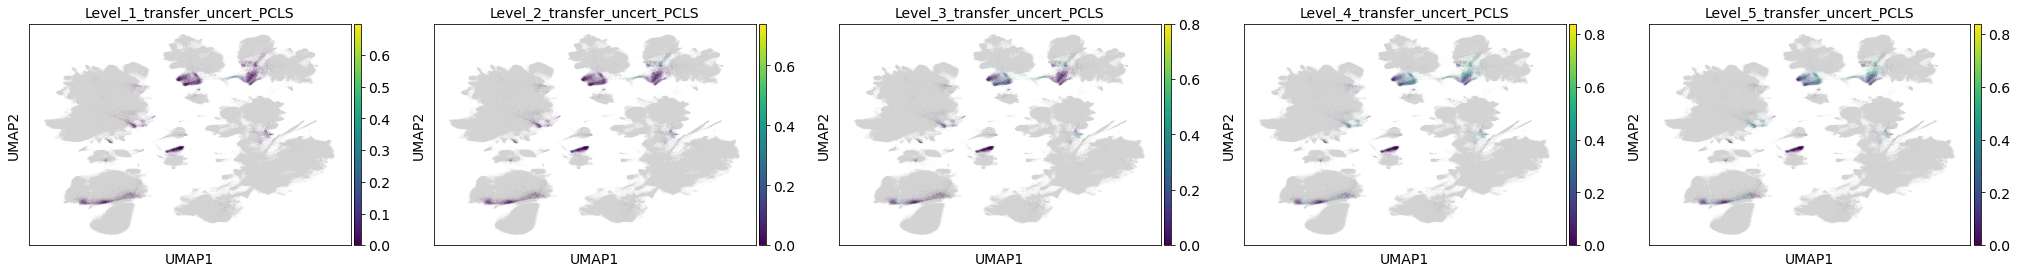

In [134]:
sc.pl.umap(combined_emb, color=[f"Level_{lev}_transfer_uncert_PCLS" for lev in range(1,6)],ncols=5)

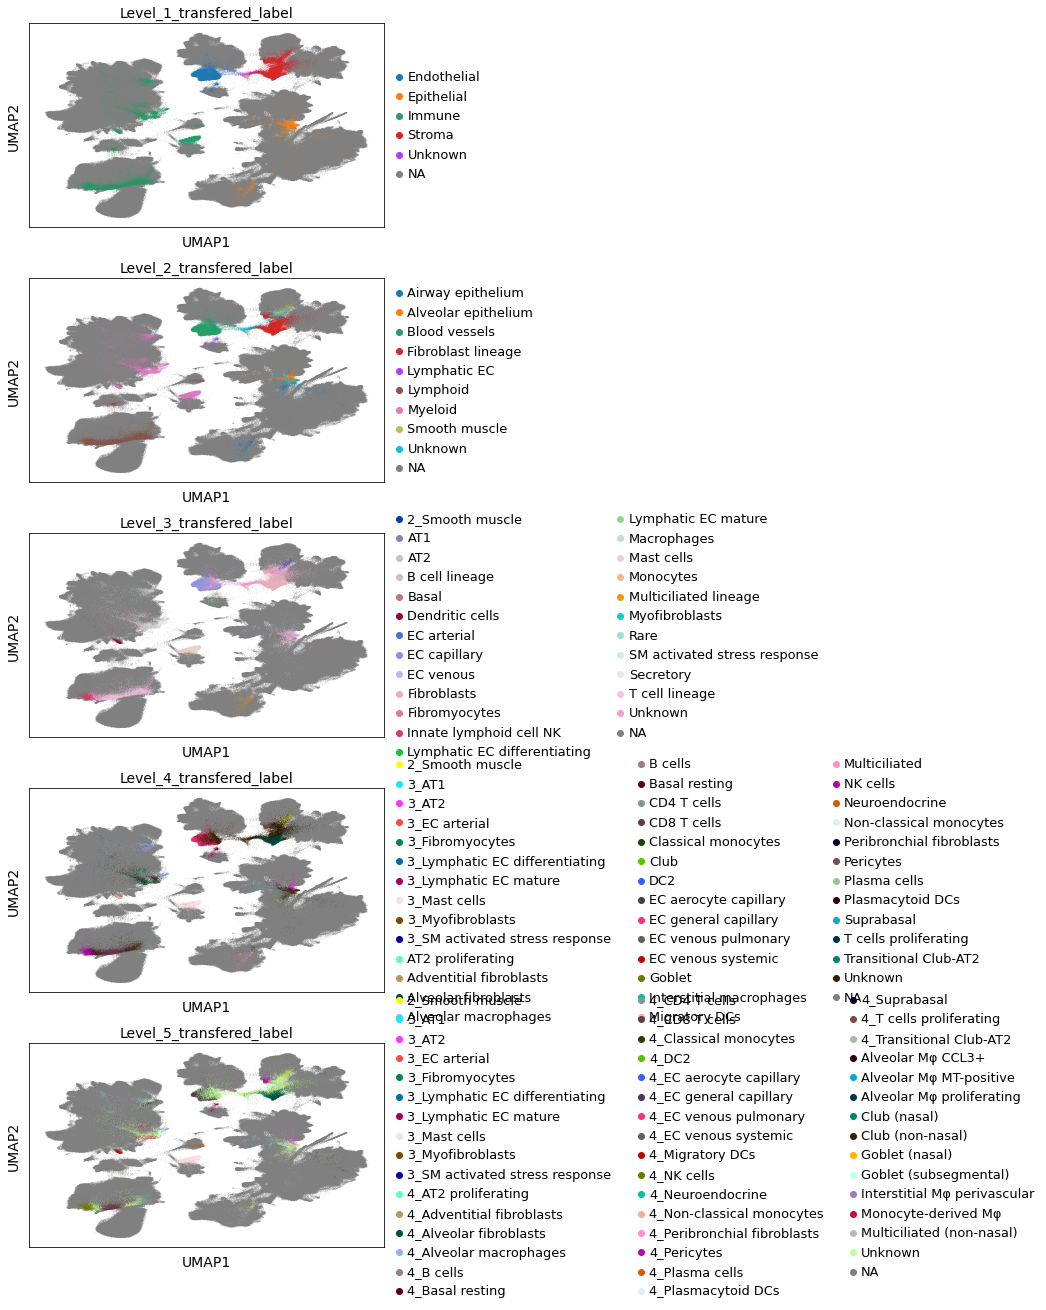

In [136]:
sc.pl.umap(combined_emb, color=[f"Level_{lev}_transfered_label" for lev in range(1,6)], na_color="grey", ncols=1, size=0.5)

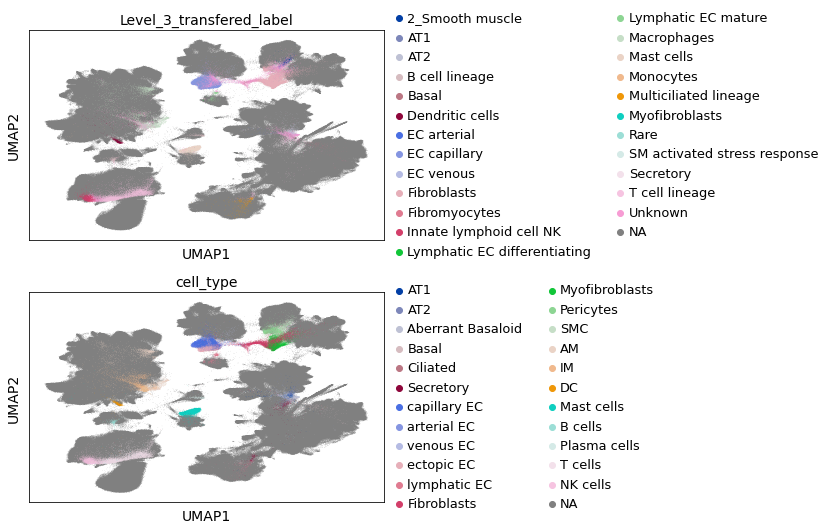

In [139]:
sc.pl.umap(combined_emb,color=["Level_3_transfered_label", "cell_type"], na_color="grey", ncols=1, size=0.5)

<AxesSubplot:xlabel='Level_3_transfered_label'>

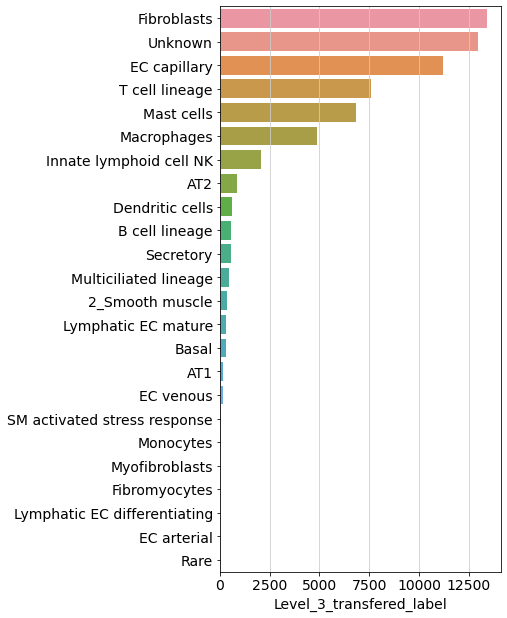

In [144]:
cell_types_n = pd.DataFrame(combined_emb.obs["Level_3_transfered_label"].value_counts())

plt.figure(figsize=(5, 10))
sns.barplot(x=cell_types_n["Level_3_transfered_label"], y=cell_types_n.index, orient="h", order=cell_types_n.index)

In [141]:
pd.DataFrame(combined_emb.obs[["Level_3_transfered_label", "cell_type"]].value_counts()[:50], columns=["count"])

count
Level_3_transfered_label cell_type               
T cell lineage           T cells             7321
Fibroblasts              Myofibroblasts      6892
Mast cells               Mast cells          6832
EC capillary             capillary EC        6238
Fibroblasts              Fibroblasts         4597
EC capillary             ectopic EC          4267
Macrophages              AM                  2719
                         IM                  2143
Unknown                  capillary EC        2120
Innate lymphoid cell NK  NK cells            2023
Unknown                  Fibroblasts         1824
                         ectopic EC          1754
Fibroblasts              Pericytes           1731
Unknown                  SMC                 1273
                         Aberrant Basaloid   1166
                         IM                  1081
                         Pericytes           1036
                         NK cells             763
Dendritic cells          DC                   525
EC capillary             arterial EC          504
AT2                      Aberrant Basaloid    405
Unknown                  AM                   378
Multiciliated lineage    Ciliated             341
B cell lineage           B cells              331
AT2                      AT2                  329
Secretory                Secretory            325
Lymphatic EC mature      lymphatic EC         316
2_Smooth muscle          SMC                  311
Unknown                  T cells              293
B cell lineage           Plasma cells         226
Unknown                  AT1                  222
Fibroblasts              SMC                  200
Unknown                  AT2                  196
T cell lineage           NK cells             184
Basal                    Basal                172
Unknown                  Myofibroblasts       156
                         lymphatic EC         135
                         venous EC            129
EC venous                venous EC            117
Unknown                  Secretory            116
Secretory                AT2                  110
AT2                      AT1                  108
Basal                    Fibroblasts           96
Unknown                  arterial EC           91
Secretory                Aberrant Basaloid     89
AT1                      AT1                   87
Unknown                  Mast cells            86
EC capillary             Fibroblasts           84
Unknown                  Basal                 84
Dendritic cells          IM                    74

In [142]:
pairwise_types_counts = pd.DataFrame(combined_emb.obs[["Level_3_transfered_label", "cell_type"]]\
                                     .value_counts(), columns=["count"])\
                                     .reset_index()\
                                     .pivot(index="Level_3_transfered_label", columns="cell_type", values="count")\
                                     .fillna(0)
pairwise_types_counts

cell_type,AT1,AT2,Aberrant Basaloid,Basal,Ciliated,Secretory,capillary EC,arterial EC,venous EC,ectopic EC,...,Pericytes,SMC,AM,IM,DC,Mast cells,B cells,Plasma cells,T cells,NK cells
Level_3_transfered_label,,,,,,,,,,,,,,,,,,,,,
2_Smooth muscle,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,57.0,311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1,87.0,2.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT2,108.0,329.0,405.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B cell lineage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,0.0,0.0,6.0,2.0,331.0,226.0,0.0,1.0
Basal,5.0,0.0,41.0,172.0,2.0,2.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0
Dendritic cells,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,74.0,525.0,0.0,3.0,0.0,0.0,0.0
EC arterial,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EC capillary,0.0,0.0,0.0,0.0,0.0,0.0,6238.0,504.0,38.0,4267.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
EC venous,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,117.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 720x720 with 0 Axes>

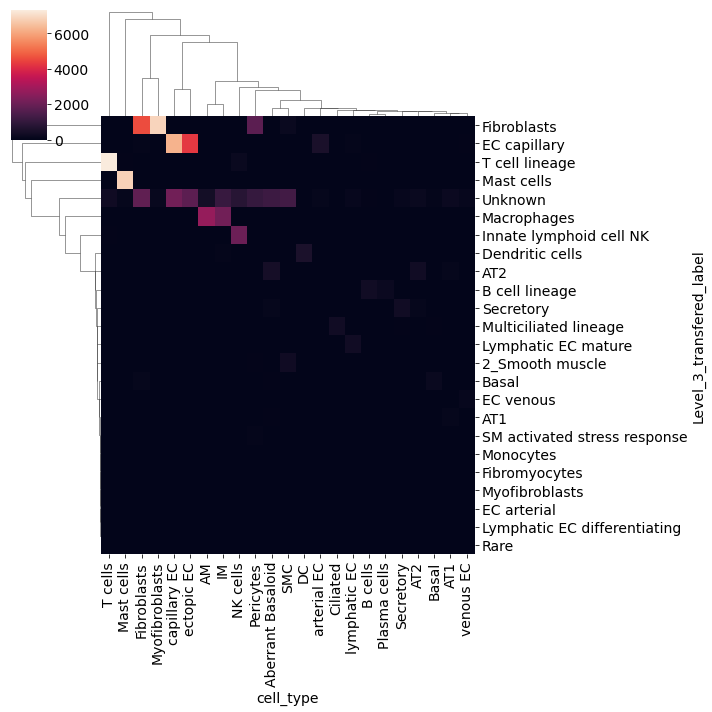

In [143]:
plt.figure(figsize=(10, 10))
sns.clustermap(pairwise_types_counts)

# Disease classification

In [11]:
combined_emb = sc.read(os.path.join(dir_out, f"../data/combined_embedding_HLCA_extended_subset{KL_NAME}.h5ad"))
combined_emb

AnnData object with n_obs × n_vars = 1086124 × 30
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 'l

In [12]:
interesting_conditions = ["IPF",
                          "Systemic sclerosis-associated ILD",
                          "End-stage lung fibrosis, unknown etiology",
                          "Myositis-associated ILD",
                          "ILD"]

In [13]:
combined_emb.shape

(1086124, 30)

Remove poorly mapped dataset

In [15]:
combined_emb = combined_emb[combined_emb.obs["study"] != "Barbry_unpubl", :].copy()
combined_emb.shape

(985913, 30)

Subset cells that are either part of core atlas or in the interesting conditions

In [16]:
cells_to_take = (combined_emb.obs["condition"].isin(interesting_conditions)) | \
                (combined_emb.obs["core_or_extension"] == "core") | \
                (combined_emb.obs["dataset"] == "PCLS")

combined_emb = combined_emb[cells_to_take, :].copy()
combined_emb.shape

(985913, 30)

In [73]:
# combined_emb.obs["binary_condition"] = combined_emb.obs["is_healthy"].map({True: "healthy", False: "disease"})
# combined_emb.obs.drop(["is_healthy"], axis=1, inplace=True)

/home/icb/vladimir.shitov/software/miniconda3/envs/HLCA_mapping_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


In [17]:
reference_embedding = combined_emb[
    combined_emb.obs["HLCA_or_query"] == "HLCA", :]

query_embedding = combined_emb[
    combined_emb.obs["HLCA_or_query"] != "HLCA", :]

In [18]:
reference_embedding.obs["condition"].value_counts()

Healthy                                      523962
IPF                                          251406
Healthy (tumor adjacent)                      60982
Systemic sclerosis-associated ILD             57287
End-stage lung fibrosis, unknown etiology     17526
Myositis-associated ILD                        7163
ILD                                            4006
Name: condition, dtype: int64

In [19]:
query_embedding.obs["condition"].value_counts()

Fibrotic Cocktail + Treatment    27462
Fibrotic Cocktail                19029
Control Cocktail                 17090
Name: condition, dtype: int64

In [20]:
reference_embedding.obs["binary_condition"].value_counts()

healthy    584944
disease    337388
Name: binary_condition, dtype: int64

In [21]:
query_embedding.obs["binary_condition"].value_counts()

disease    46491
healthy    17090
Name: binary_condition, dtype: int64

In [22]:
combined_emb.obs["condition"].value_counts()

Healthy                                      523962
IPF                                          251406
Healthy (tumor adjacent)                      60982
Systemic sclerosis-associated ILD             57287
Fibrotic Cocktail + Treatment                 27462
Fibrotic Cocktail                             19029
End-stage lung fibrosis, unknown etiology     17526
Control Cocktail                              17090
Myositis-associated ILD                        7163
ILD                                            4006
Name: condition, dtype: int64

#### KNN classifier

In [ ]:
# perform label transfer
labels, uncert = scarches_label_transfer.weighted_knn_transfer(
    query_adata=query_embedding,
    query_adata_emb="X", # location of our joint embedding
    label_keys="binary_condition",
    knn_model=k_neighbors_transformer,
    ref_adata_obs = reference_embedding.obs,
)

In [36]:
labels.head()

,binary_condition
muc31175_AAACCCAAGATCCCGC,healthy
muc31175_AAACCCAAGTAAAGCT,disease
muc31175_AAACCCACAAGTTGGG,healthy
muc31175_AAACCCACACCAAAGG,healthy
muc31175_AAACCCACACCTCGTT,healthy


In [37]:
uncert.head()

,binary_condition
muc31175_AAACCCAAGATCCCGC,0.359994
muc31175_AAACCCAAGTAAAGCT,0.200007
muc31175_AAACCCACAAGTTGGG,0.120002
muc31175_AAACCCACACCAAAGG,0.179991
muc31175_AAACCCACACCTCGTT,0.26


In [38]:
labels.rename(columns={"binary_condition": "binary_condition_transfered_label_unfiltered"}, inplace=True)
uncert.rename(columns={"binary_condition": "binary_condition_transfer_uncert"}, inplace=True)

In [40]:
uncertainty_threshold = 0.2

In [45]:
combined_emb.obs.drop(["binary_condition_transfer_uncert", "binary_condition_transfered_label_unfiltered"], axis=1, inplace=True)

In [46]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)
# convert to arrays instead of categoricals, and set "nan" to NaN 

combined_emb.obs["binary_condition_transfer_uncert"] = list(np.array(combined_emb.obs["binary_condition_transfer_uncert"]))

col = "binary_condition_transfered_label_unfiltered"
filtered_colname = col.replace("_unfiltered","")
matching_uncert_col = col.replace("transfered_label_unfiltered", "transfer_uncert")

# also create a filtered version, setting cells with too high 
# uncertainty levels to "Unknown"
combined_emb.obs[filtered_colname] = combined_emb.obs[col]
combined_emb.obs[filtered_colname].loc[
    combined_emb.obs[matching_uncert_col] > uncertainty_threshold] = "Unknown"
# convert to categorical:
combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
# then replace "nan" with NaN (that makes colors better in umap)
combined_emb.obs[col].replace("nan", np.nan, inplace=True)
combined_emb.obs[filtered_colname].replace("nan",np.nan,inplace=True)

/home/icb/vladimir.shitov/software/miniconda3/envs/HLCA_mapping_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [47]:
combined_emb

AnnData object with n_obs × n_vars = 985913 × 30
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 'lo

In [49]:
combined_emb.write(os.path.join(dir_out, f"../data/combined_embedding_HLCA_extended_subset{KL_NAME}.h5ad"))

In [50]:
print(f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:")
print(f"condition: {np.round(sum(combined_emb.obs['binary_condition_transfered_label'] =='Unknown')/query_embedding.n_obs*100,2)}%")

Percentage of unknown per level, with uncertainty_threshold=0.2:
condition: 52.73%


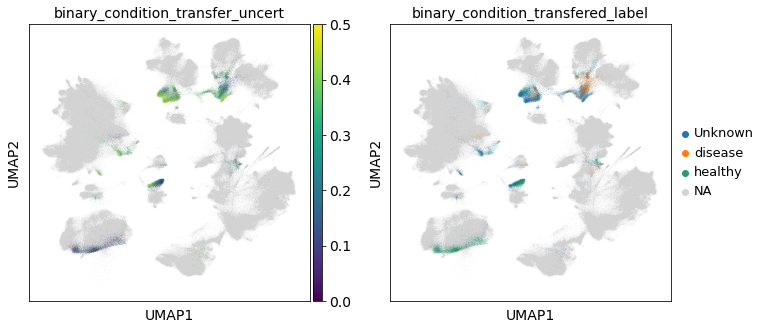

In [51]:
sc.pl.umap(combined_emb, color=["binary_condition_transfer_uncert", "binary_condition_transfered_label"], ncols=2)